<a href="https://colab.research.google.com/github/drkrillo/DATASCIENCE/blob/main/DS_ProyectoFinal_Pasutti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID - 19: Entendiendo la Pandemia

# Introducción

Durante los últimos dos años, el mundo se enfrentó a un virus sin igual: muchos países tuvieron que tomar decisiones drásticas para proteger a sus ciudadanos, y otros sufriendo mucho dado que la enfermedad se dio a conocer en estos lugares.
Este informe pretende analizar **los primeros días de la pandemia** . A través de un simple modelado exponencial, en donde las variables a considerar sólo dependen del tiempo, no se puede intentar entender toda la curva de contagios de una manera tan simple. Para modelar estos casos complejos, existen modelos como el SEIR, que tiene en consideración a la población susceptible, infectada, expuesta y recuperada. Para más inforóman, ver la investiógacin adicional.

### Tabla de contenidos 

1. Exploratory Data Analysis y Data Pre-Processing

  1.1 Analizando las Features

  1.2 Separación del dataset en Países. Pre-Procesado

  1.3 Observaciones

2. Ajuste Exponencial

  2.1 Selección de Países

  2.2 Selección de Ventana Temporal

      * Observaciones

  2.2 Comparación de K para cada país

  2.3 Calculando el K mundial

      * Observaciones y Conclusiones

3. Analizando Estrategias

  3.1 Observaciones

  3.2 Selección de Estrategias

      * Observaciones

  3.3 Selección de Países 

      * Observaciones

  3.4 Diseño e Interpretación de las Regresiones Logísticas

4. Resultados y Conclusiones

5. Investigación Adicional: Resolviendo un sistema SEIR

6. Cierre del Trabajo

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/DATASCIENCE/

/content/gdrive/MyDrive/DATASCIENCE


In [ ]:
#función para ajustar modelo
def exponential(t,k,t0):
  
  C=np.exp(k*(t-np.abs(t0))) # Valor absolluto para que no pueda ser negativo
  return C

#función para regresión logística
def sigmoid(x,x0, k):

    y = 1 / (1 + np.exp(-k*(x-x0)))
    return (y)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as st
import seaborn as sns

In [ ]:
df = pd.read_csv('owid-covid-data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121247 entries, 0 to 121246
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   iso_code                                 121247 non-null  object 
 1   continent                                115723 non-null  object 
 2   location                                 121247 non-null  object 
 3   date                                     121247 non-null  object 
 4   total_cases                              115114 non-null  float64
 5   new_cases                                115111 non-null  float64
 6   new_cases_smoothed                       114096 non-null  float64
 7   total_deaths                             104318 non-null  float64
 8   new_deaths                               104473 non-null  float64
 9   new_deaths_smoothed                      114096 non-null  float64
 10  total_cases_per_million         

In [ ]:
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121242,ZWE,Africa,Zimbabwe,2021-09-30,130820.0,335.0,240.857,4623.0,7.0,3.286,8668.070,22.197,15.959,306.318,0.464,0.218,1.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6510.0,1270043.0,84.152,0.431,5024.0,0.333,0.048,20.9,tests performed,5355820.0,3083764.0,2272056.0,NaN,35255.0,27045.0,35.49,20.43,15.05,NaN,1792.0,36.11,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
121243,ZWE,Africa,Zimbabwe,2021-10-01,131028.0,208.0,270.571,4624.0,1.0,3.429,8681.852,13.782,17.928,306.384,0.066,0.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3736.0,1273779.0,84.400,0.248,4626.0,0.307,0.058,17.1,tests performed,5387135.0,3097001.0,2290134.0,NaN,31315.0,27110.0,35.69,20.52,15.17,NaN,1796.0,36.11,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,

### Analizando las Features

Como se puede observar de las celdas anteriores, el dataset cuenta con **mucha** información.
Algunas features son de particular importancia para nuestro análisis: **todas aquellas relacionadas a la cantidad total de contagios o muertes(total cases, new cases, new deaths, total deaths, etc) y aquellas relacionadas a vacunaciones**.
Otras, como aquellas relacionadas a **excess mortality, life expectancy, smokers, cardiovascular death rate, human development index** y otras, no parecen tener una relación directa con lo que se intenta estudiar. 
Algunas relacionadas a la cantidad de entradas al hospital o en terapia intensiva podrían resultar de utilidad para un estudio mas riguroso. En este informe no serán utilizadas.

### Separando el dataset por Países. Pre-Procesado.

Para trabajar más comodamente con los datos, y poder hacer análisis particulares para cada uno, se serpará el dataset original por países y se le establecerá el índice en fechas con una frecuencia diaria.
Dado que el número total de casos es nulo antes del primer contagio, y no vuelve a serlo, se dejarán de lado las entradas nulas en esta columna, para así poder tener cada serie de tiempo con su primer instancia el día del primer contagio de COVID-19 en ese país.

In [ ]:
todos_paises = []

for i in df.iso_code.unique():
  
  exec(f'df_{i} = df[df.iso_code == i]')
  exec(f'df_{i}.date = pd.to_datetime(df_{i}.date)')
  exec(f'df_{i}.set_index(df_{i}.date, inplace = True)')
  exec(f'df_{i} = df_{i}.asfreq("d")')
  exec(f'df_{i}.drop(columns = ["date"], inplace = True)')
  exec(f'df_{i}.dropna(subset = ["total_cases"], inplace = True)')
  
  todos_paises.append('df_'+i)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### Observaciones

Ahora que están los datasets por país, se han estudiado los diferentes features, y se han planteado los primeros pasos a seguir, se continuará con el ajuste exponencial.

## Ajuste Exponencial

Para el ajuste exponencial, se considerará el siguiente modelo simple: $$contagios = e^{k(t - t_{0})}$$

Donde t representa el tiempo actual, t0 es el día del primer contagio y **k es nuestra constante de crecimiento exponencial, el valor que queremos aproximar**.

### Selección de Países

Para que el estudio sea representativo, para las visualizaciones se eligirán países de todos los continentes, de ambos hemisferios, y con diferentes cualidades económicas, ideológicas, etc. Estos serán: **Argentina, Filipinas, Perú, Alemania, Irán, Francia, Italia, Finlandia, Bélgica, Taiwán, Bangladesh y Estados Unidos**.

In [ ]:
seleccion_paises = ['df_ARG', 'df_PHL', 'df_PER', 'df_DEU', 
                    'df_IRN', 'df_FRA', 'df_ITA','df_FIN',
                    'df_BEL', 'df_TWN', 'df_BGD', 'df_USA']
paises = ['Argentina', 'Filipinas', 'Perú', 'Alemania', 'Irán', 
          'Francia', 'Italia', 'Finlandia', 'Bélgica', 'Taiwán', 
          'Bangladesh', 'Estados Unidos']

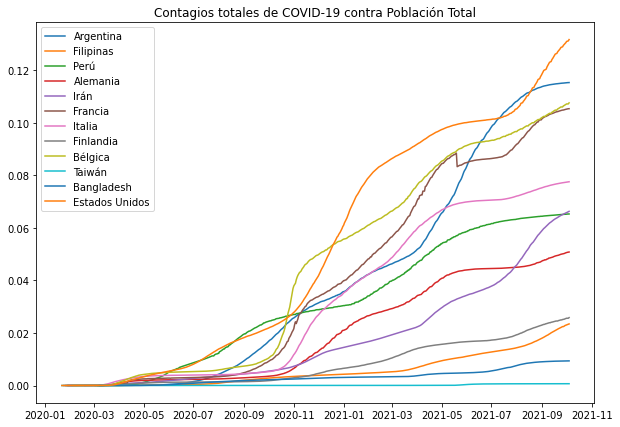

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
i = 0

while i < 12:    
  
  plt.plot(globals()[seleccion_paises[i]].total_cases / globals()[seleccion_paises[i]].population, label = paises[i])
  plt.legend()
  i = i + 1

plt.title('Contagios totales de COVID-19 contra Población Total')
plt.show()

### Selección de Ventana Temporal

Como se había dicho anteriormente, no es lógico aplicar el ajuste exponencial a cualquier ventana temporal. De hecho, tampoco sería razonable calcular el ajuste para **la misma ventana temporal para cada país**. ¿Por qué? Es sabido que la enfermedad no llegó a todo el mundo en el mismo momento. Si tomamos como ventana temporal de febrero a marzo, por ejemplo, muchos países del hemisferio sur no presentarían casos. Por eso, la ventana temporal que se eliga **será desde el primer día de contagios en cada uno de los países**.

Como también se dijo más arriba, las políticas públicas aplicadas cambian la curva de contagios, y la alejan de una función exponencial estática. Es necesario captar una ventana temporal corta, en un lapso de tiempo en donde se tengan **datos fehacientes** sobre las políticas aplicadas.

Text(0.5, 0.98, 'Primeros días de contagio - COVID-19')

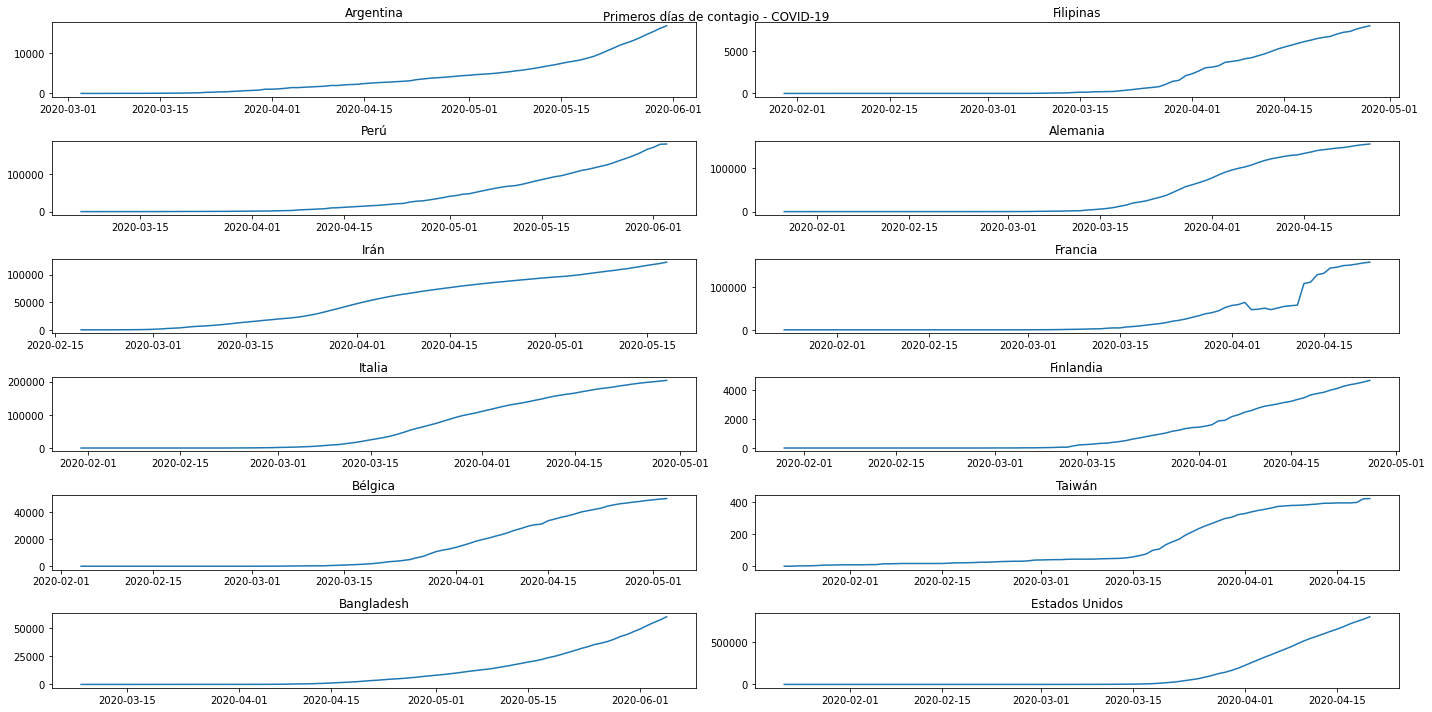

In [ ]:
i = 0 
plt.figure(figsize=(20,10))

while i < 12:

  plt.subplot(6,2, i+1)
  plt.plot(globals()[seleccion_paises[i]].total_cases[:90])
  plt.title(paises[i])
  i = i + 1 

plt.tight_layout()
plt.suptitle('Primeros días de contagio - COVID-19')

Text(0.5, 0.98, 'Segundo Mes de contagios(Escala logarítmica) - COVID-19')

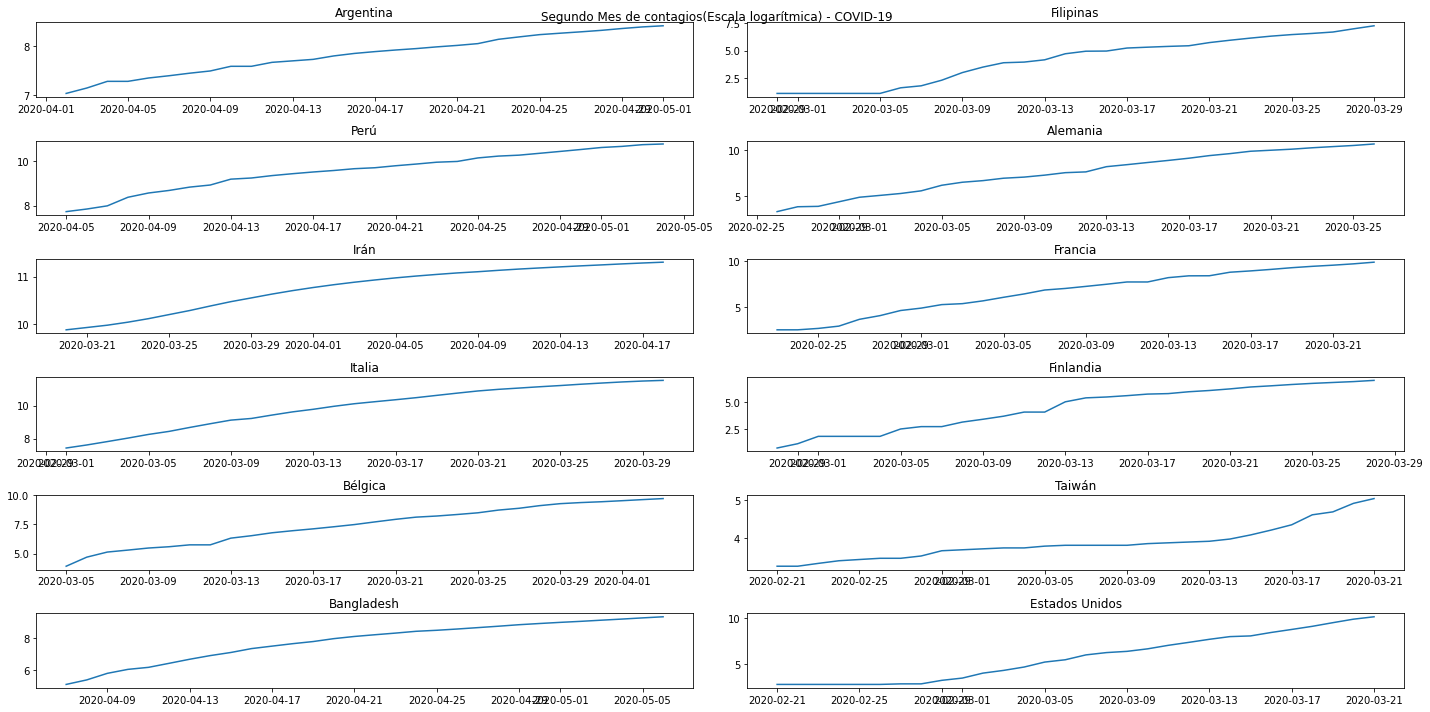

In [ ]:
i = 0
plt.figure(figsize=(20,10))

while i < 12:

  plt.subplot(6,2, i+1)
  plt.plot(np.log(globals()[seleccion_paises[i]].total_cases[30:60]))
  plt.title(paises[i])
  i = i + 1 

plt.tight_layout()
plt.suptitle('Segundo Mes de contagios(Escala logarítmica) - COVID-19')

#### Observaciones

A partir de los gráficos anteriores sobre nuestra selección de países, se tomarán los registros desde el día 30 al día 60 desde el primer contagio por país para calcular el ajuste exponencial con su debido K. Durante este lapso, la mayoría de estos países parecen mantener una relación logarítmica entre la cantidad de contagios y el tiempo transcurrido.

**Esto puede observarse fácilmente en el gráfico con eje y logarítimico, que presenta(con sus sutilizas) una curva lineal**.

In [ ]:
dias = np.arange(30,60)
paises_notempty = []
k_paises = []
t0_paises = []
paises2 = todos_paises

todos_paises.remove('df_CHN')

In [ ]:
for i in todos_paises:

  if (globals()[i].empty == False) & (len(globals()[i]) > 100):

    if globals()[i].total_cases[60] > globals()[i].total_cases[30] + 1000:
      
      popt, pcov = curve_fit(exponential, dias, globals()[i].total_cases[30:60])
      k_paises.append(popt[0])
      t0_paises.append(popt[1])
      paises_notempty.append(i)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


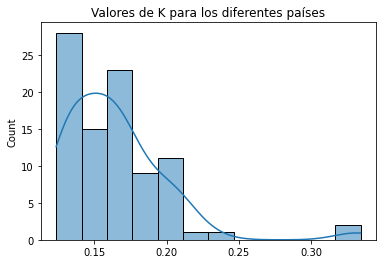

In [ ]:
sns.histplot(k_paises, kde = True)
plt.title('Valores de K para los diferentes países')
plt.show()

Text(0.5, 0.98, 'Segundo mes de contagios - Ajuste Exponencial')

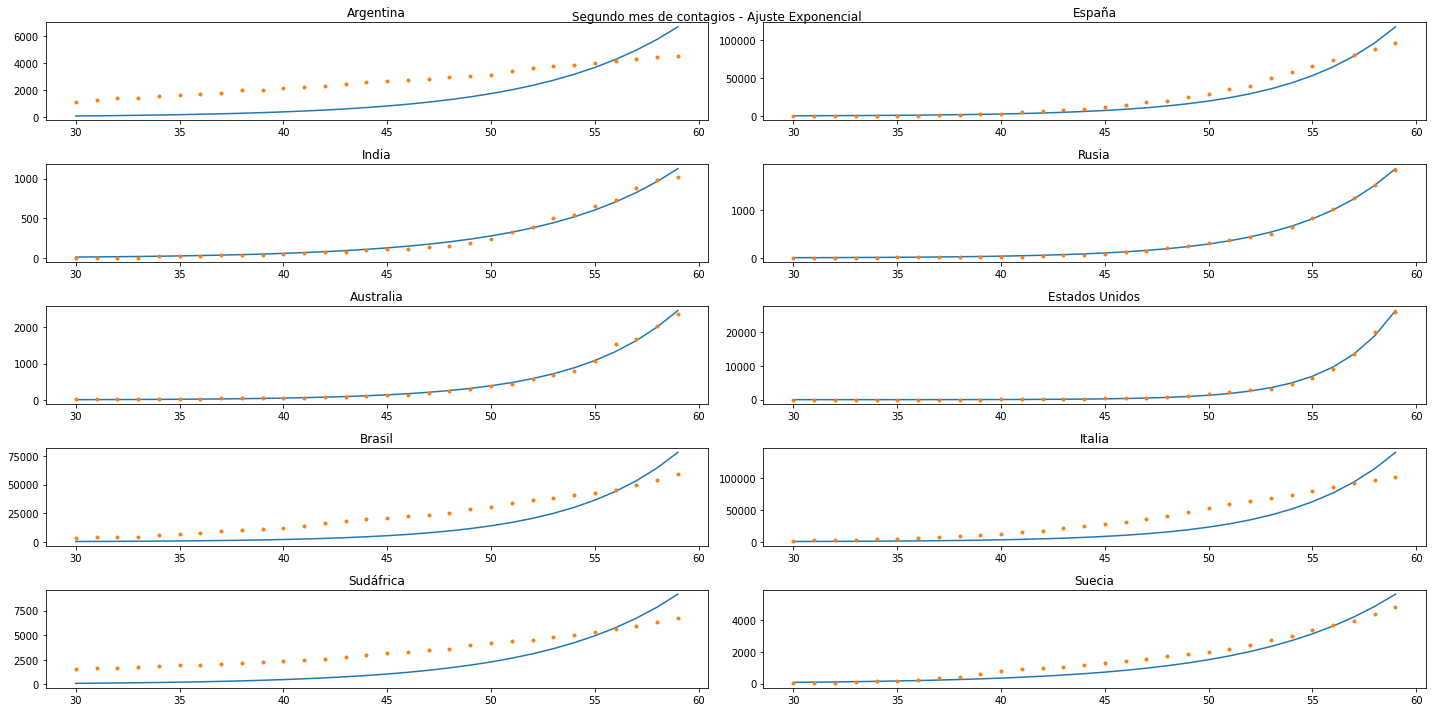

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(521)
plt.plot(dias, exponential(dias, k_paises[3], t0_paises[3]))
plt.plot(dias, df_ARG.total_cases[30:60],'.')
plt.title('Argentina')

plt.subplot(522)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_ESP')],
                          t0_paises[paises_notempty.index('df_ESP')]))
plt.plot(dias, df_ESP.total_cases[30:60], '.')
plt.title('España')

plt.subplot(523)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_IND')],
                          t0_paises[paises_notempty.index('df_IND')]))
plt.plot(dias, df_IND.total_cases[30:60], '.')
plt.title('India')

plt.subplot(524)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_RUS')],
                          t0_paises[paises_notempty.index('df_RUS')]))
plt.plot(dias, df_RUS.total_cases[30:60], '.')
plt.title('Rusia')

plt.subplot(525)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_AUS')],
                          t0_paises[paises_notempty.index('df_AUS')]))
plt.plot(dias, df_AUS.total_cases[30:60], '.')
plt.title('Australia')

plt.subplot(526)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_USA')],
                          t0_paises[paises_notempty.index('df_USA')]))
plt.plot(dias, df_USA.total_cases[30:60], '.')
plt.title('Estados Unidos')

plt.subplot(5,2,7)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_BRA')],
                          t0_paises[paises_notempty.index('df_BRA')]))
plt.plot(dias, df_BRA.total_cases[30:60], '.')
plt.title('Brasil')

plt.subplot(528)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_ITA')],
                          t0_paises[paises_notempty.index('df_ITA')]))
plt.plot(dias, df_ITA.total_cases[30:60], '.')
plt.title('Italia')

plt.subplot(529)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_ZAF')],
                          t0_paises[paises_notempty.index('df_ZAF')]))
plt.plot(dias, df_ZAF.total_cases[30:60], '.')
plt.title('Sudáfrica')

plt.subplot(5,2,10)
plt.plot(dias,exponential(dias, k_paises[paises_notempty.index('df_SWE')],
                          t0_paises[paises_notempty.index('df_SWE')]))
plt.plot(dias, df_SWE.total_cases[30:60], '.')
plt.title('Suecia')

plt.tight_layout()
plt.suptitle('Segundo mes de contagios - Ajuste Exponencial')

### Comparando K para los diferentes Países

De los gráficos arriba expuestos pueden sacarse varias conclusiones.

1. Por un lado, se puede observar que la mayoría de los países presentan un K **similar** en la ventana temporal elegida. Algunos pocos países exceden por mucho al resto. En este informe se deja de lado este análisis, pero abre la puerta a muchos caminos de investigación.

2. De los gráficos por país y sus respectivos ajustes, se puede observar que **no todos los ajustes se adaptan bien a los datos**. Para explicar esta situación podemos plantear varias hipótesis iniciales. Por ejemplo, que estos países ya estaban aplicando alguna política de cuarentena o de cierre de fronteras, y por eso la curva no se adapta bien a una función exponencial. También, podría ser el caso contrario, que el crecimiento es tan elevado, que ya superó la parte exponencial, y ahora se comporta de manera lineal, pero con un **crecimiento muy elevado**. De todas formas, esto también queda por fuera de los intereses de este proyecto, y simplemente se plantean para ofrecer caminos de investigación alternativos o para profundizar en alguna problemática.

In [ ]:
k_interval = st.t.interval(0.99, len(k_paises)-1, loc=np.mean(k_paises), scale=st.sem(k_paises))

### Calculando el K Mundial

Ahora que ya tenemos los datos por país y sus respectivos K durante el segundo mes de contagios, se analizará la tendencia **mundial** de la curva de contagios.

Para esto, crearemos una nueva tabla, calcularemos el K, y se verá si éste entra dentro del intervalo de confianza del 99% para los K individuales por país.

#### Ajuste de la ventana temporal

Dado que, como se nombraba anteriormente, los contagios dependen enn gran medida de la ubicación geográfica y de las políticas internacionales, para este cálculo se tomará una ventana temporal del día 60 al día 90, es decir, un mes después que para el ajuste por país.

Si se analiza esto, tiene sentido. Muchos países del hemisferio sur tuvieron su primer caso un mes(o hasta un poco más) después que los países del hemisferio norte. Para hacer un ajuste representativo, es necesario tener esto en cuenta. Por esta razón, la ventana se adelanta en el tiempo un mes, para poder capturar estas diferencias.

In [ ]:
fechas = []
contagios_mundiales = []

for i in df.date.unique():
  
  contagios = df.loc[df['date'] == i,['total_cases']].sum()
  contagios_mundiales.append(int(contagios))
  fechas.append(i)

In [ ]:
d = {'date': fechas, 'total_cases': contagios_mundiales}
df_MUNDIAL = pd.DataFrame(d)
df_MUNDIAL.date = pd.to_datetime(df_MUNDIAL.date)
df_MUNDIAL.set_index(df_MUNDIAL.date, inplace = True)
df_MUNDIAL.drop(columns = ["date"], inplace = True)
df_MUNDIAL.sort_index(inplace = True)

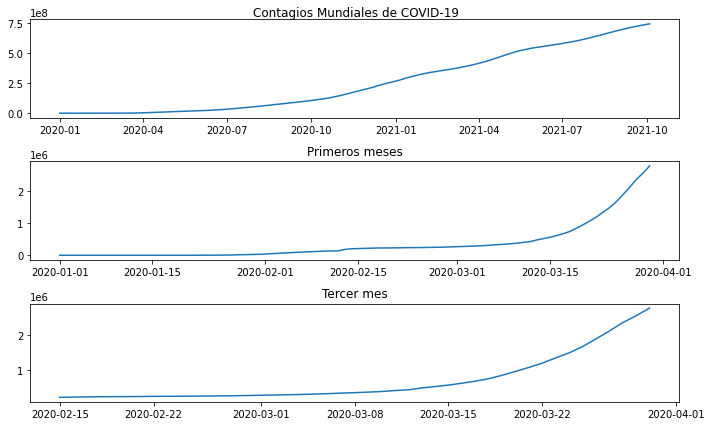

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.plot(df_MUNDIAL)

plt.subplot(3,1,2)
plt.plot(df_MUNDIAL.total_cases[0:90])
plt.title('Primeros meses')

plt.subplot(3,1,3)
plt.plot(df_MUNDIAL.total_cases[45:90])
plt.title('Tercer mes')

plt.suptitle('Contagios Mundiales de COVID-19')
plt.tight_layout()
plt.show()

In [ ]:
dias = np.arange(45,90)

popt, pcov = curve_fit(exponential, dias, df_MUNDIAL.total_cases[45:90])
k_mundial = popt[0]
t0_mundial = popt[1]

In [ ]:
k_mundial

0.16879168122799698

Text(0.5, 0, 'Días desde el primer contagio')

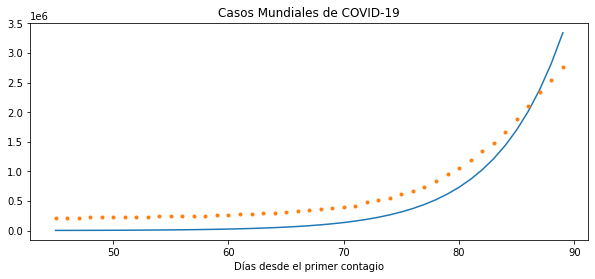

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(dias, exponential(dias, k_mundial, t0_mundial), label = 'Ajuste Exponencial')
plt.plot(dias, df_MUNDIAL.total_cases[45:90], '.', label = 'Datos reales')
plt.title('Casos Mundiales de COVID-19')
plt.xlabel('Días desde el primer contagio')

In [ ]:
k_interval[1], k_interval[0]

(0.17440042719012136, 0.15418539455966276)

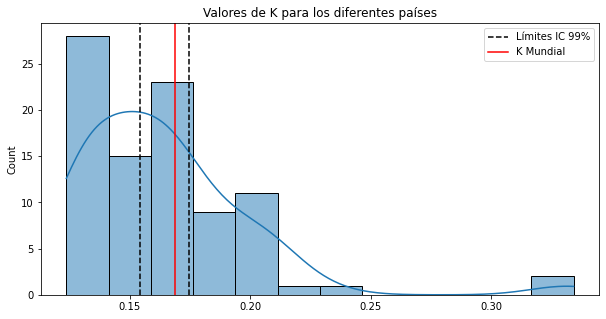

In [ ]:
plt.figure(figsize=(10,5))

sns.histplot(k_paises, kde = True)
plt.axvline(x = k_interval[0],ls = '--', color = 'black')
plt.axvline(x = k_interval[1], ls = '--', color = 'black', label = 'Límites IC 99%')
plt.axvline(x = k_mundial, label = 'K Mundial', color = 'red')
plt.title('Valores de K para los diferentes países')
plt.legend()
plt.show()

### Observaciones

Como se puede observar del gráfico anterior, el K mundial, obtenido a través del ajuste exponencial, está contenido dentro del intervalo de confianza del 99% de los K para cada país.

### Conclusiones

En un primer análisis, se puede decir que **es extrapolable el K mundial a partir del intervalo de confianza de los K individuales por país**. Sin embargo, como se puede apreciar en los gráficos de ajuste por país y en el mundial que algunos tienen un error cuadrático alto. Es decir, **la regresión no se ajuste bien a los datos**. Esto puede ser por diversas razones. La hipótesis principal es que la ventana temporal no representa la parte de crecimiento exponencial de la curva en estos casos. 

Esto deja abiertas líneas de investigación para futuras iteraciones sobre el proyecto.

## Analizando Indicadores

Para poder determinar si **un país ha implementado una política de cuarentena estricta o no**, primero es necesario estudiar algunas de las features que nos ofrece el dataset. Como primer paso, se graficarán algunas de estas series temporales, y se intentará decidir **tres indicadores** para intentar determinar, a través de regresiones logísticas, si estos indicadores funcionan o no para decidir dica política.

Text(0.5, 0.98, 'Nuevos casos. Suavizado - COVID-19')

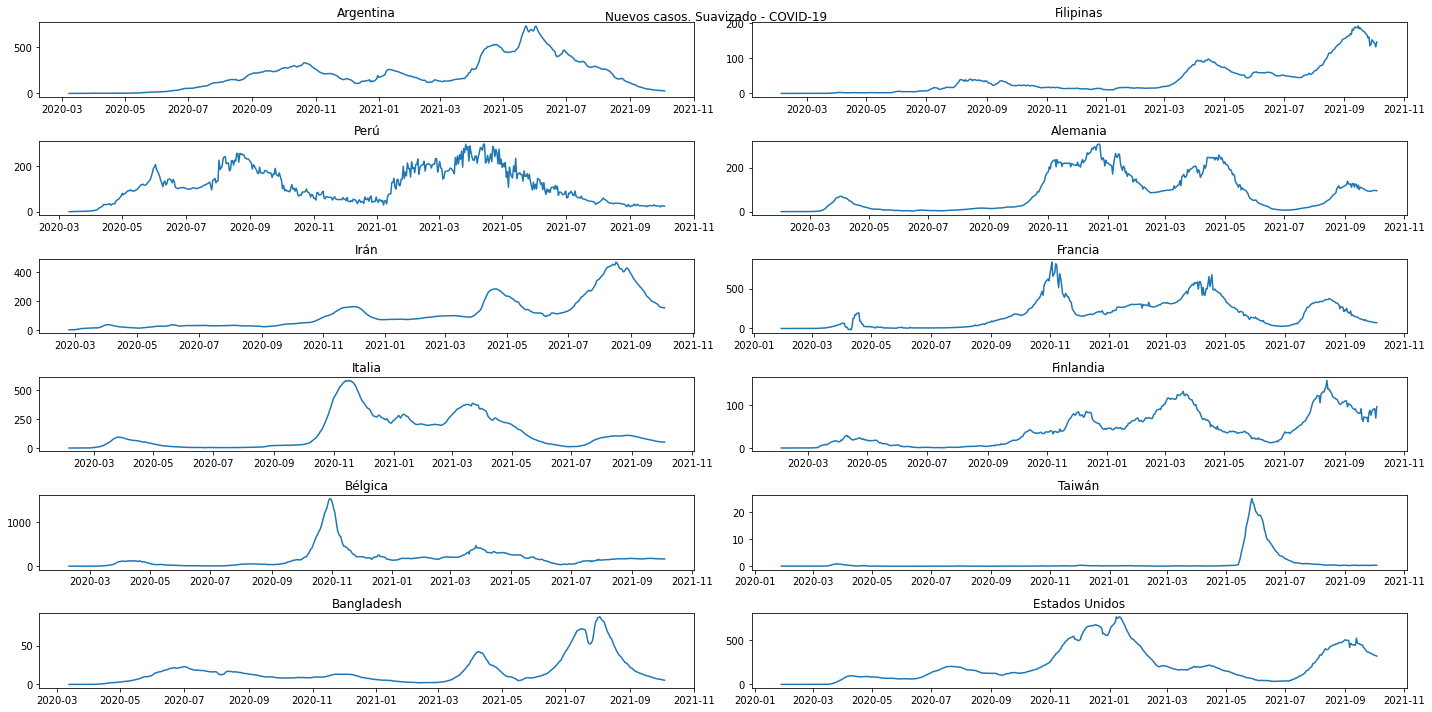

In [ ]:
i = 0
plt.figure(figsize=(20,10))

while i < 12:

  plt.subplot(6,2, i+1)
  plt.plot(globals()[seleccion_paises[i]].new_cases_smoothed_per_million)
  plt.title(paises[i])
  i = i + 1 

plt.tight_layout()
plt.suptitle('Nuevos casos. Suavizado - COVID-19')

Cantidad de nuevas muertes para saber si estan vacunados o no

Text(0.5, 0.98, 'Nuevas muertes. Suavizado - COVID-19')

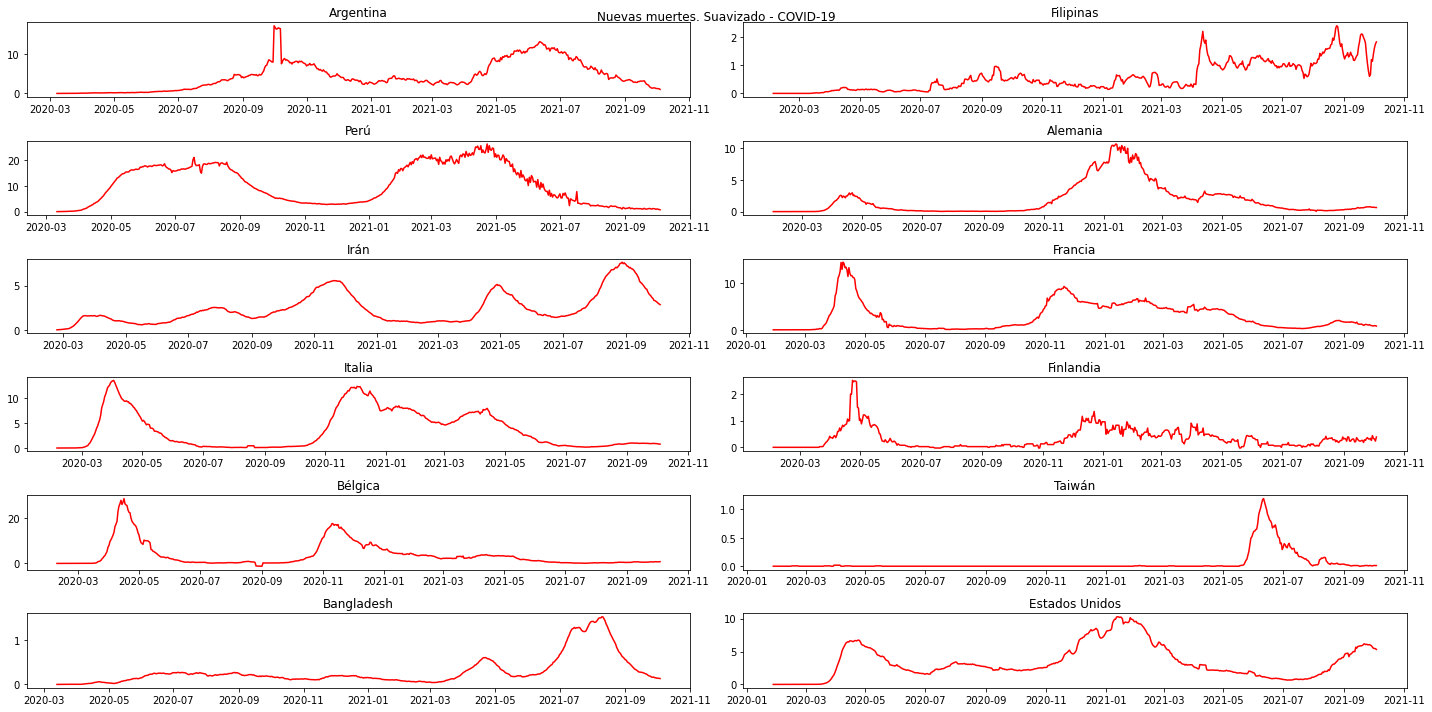

In [ ]:
i = 0
plt.figure(figsize=(20,10))

while i < 12:

  plt.subplot(6,2, i+1)
  plt.plot(globals()[seleccion_paises[i]].new_deaths_smoothed_per_million, color = 'r')
  plt.title(paises[i])
  i = i + 1 

plt.tight_layout()
plt.suptitle('Nuevas muertes. Suavizado - COVID-19')

Text(0.5, 0.98, 'Nuevas Vacunaciones. Suavizado - COVID-19')

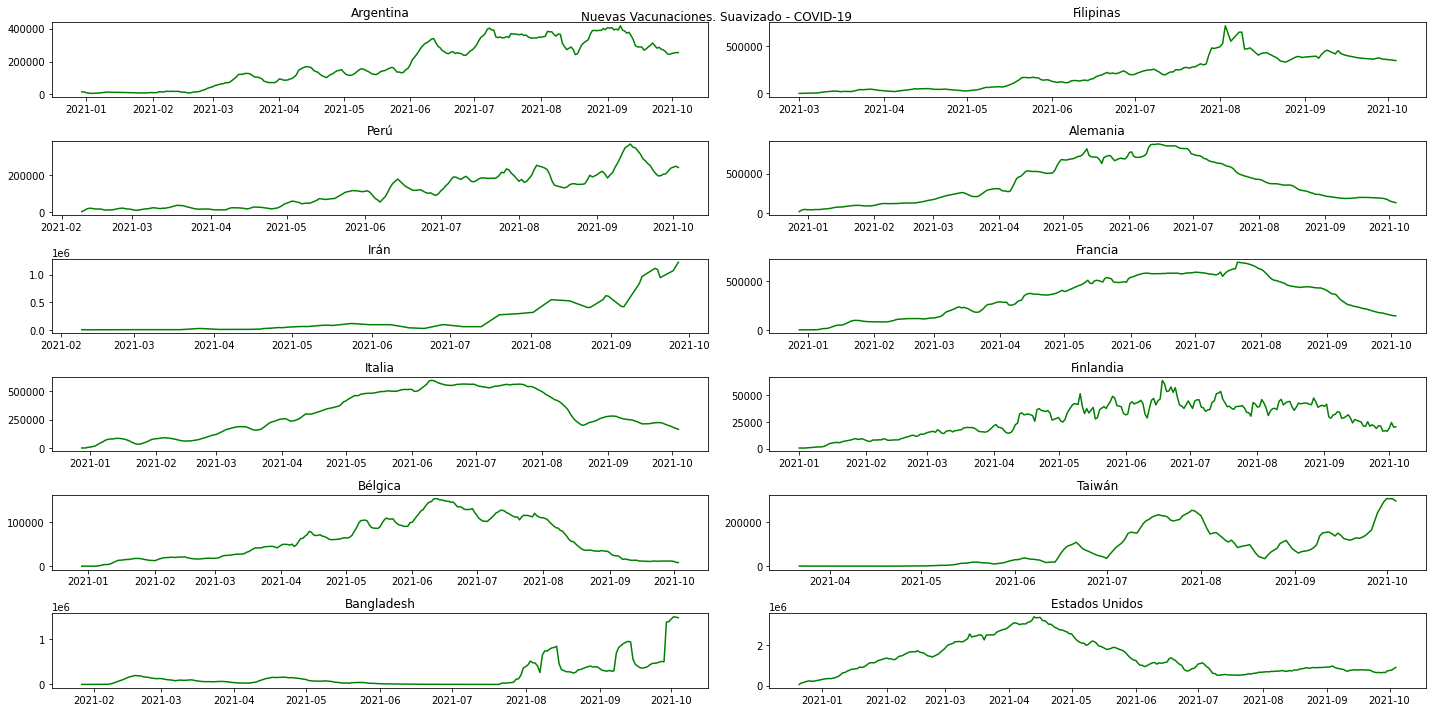

In [ ]:
i = 0
plt.figure(figsize=(20,10))

while i < 12:

  plt.subplot(6,2, i+1)
  plt.plot(globals()[seleccion_paises[i]].new_vaccinations_smoothed, color = 'green')
  plt.title(paises[i])
  i = i + 1 

plt.tight_layout()
plt.suptitle('Nuevas Vacunaciones. Suavizado - COVID-19')

Text(0.5, 0.98, 'Nuevas Vacunaciones. Suavizado - COVID-19')

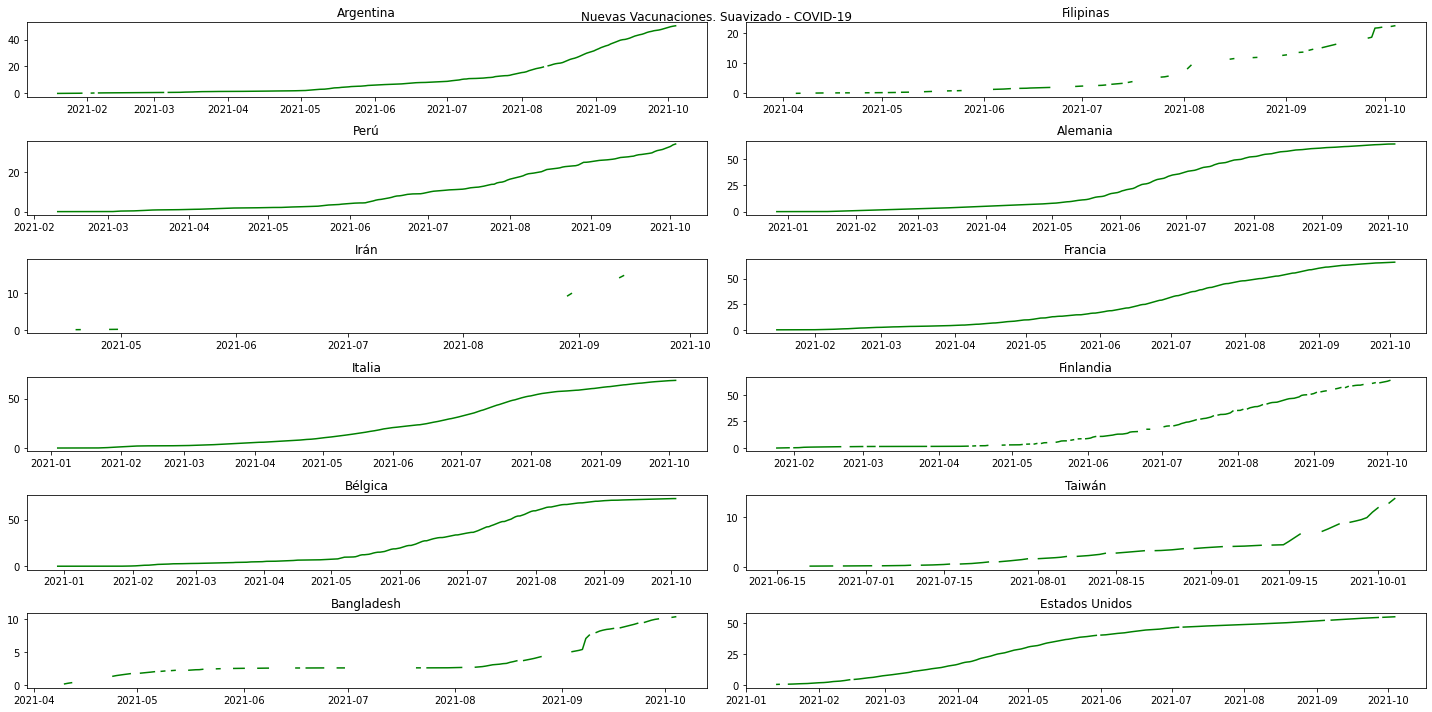

In [ ]:
i = 0
plt.figure(figsize=(20,10))

while i < 12:

  plt.subplot(6,2, i+1)
  plt.plot(globals()[seleccion_paises[i]].people_fully_vaccinated_per_hundred, color = 'green')
  plt.title(paises[i])
  i = i + 1 

plt.tight_layout()
plt.suptitle('Nuevas Vacunaciones. Suavizado - COVID-19')

### Observaciones

De los anteriores gráficos se puede concluir que durante el año 2021, el porcentaje de personas completamente vacunadas por país se elevó hasta un 40% o más en la mayoría de países. La cantidad de nuevos contagios y de muertes por millón de habitantes presentan picos a lo largo de ambos años, y parecen ser buenos candidatos como indicadores. Como se calculó en el apartado anterior, el K de cada país resulta un buen indicador de la tendencia general de contagios, por lo que también podría funcionar bien como **indicador de predicción de cuarentena**.

Como se trata de series de tiempo, y si se aplica una política de cuarentena o no, **es necesario plantear una situación de contraste** entre un momento anterior, y un momento posterior. De esta forma, analizando la diferencia entre ambos momentos previamente seleccionados, se podrá saber si el país adoptó o no dicha política.

### Selección de Indicadores

**Indicador 1**: Diferencia entre la media de contagios por millón de habitantes entre los días 30 y 45, y 15 y 30, desde el primer contagio.

**Indicador 2**: Diferencia entre la media de muertes por millón de habitantes entre los días 30 y 45, y 15 y 35, desde el primer contagio.

**Indicador 3**: Diferencia entre el K del ajuste exponencial del día 30 a 45, y 15 y 30, desde el primer contagio.

#### Hipótesis

Los tres indicadores son prometedores a primera vista. Si el indicador 1 y 2 es positivo, se asume que el número de casos y de muertes ha aumentado, y puede significar que el país en cuestión no está aplicando políticas de aislamiento social para disminuirlo. El tercer indicador, de mantenerse positivo o cerca de 0, indicaría que la curva de contagios se ha mantenido o aumentado, lo que reflejaría una que el país no tomó medidas drásticas para la reducción de casos.


In [ ]:
dias = np.arange(15, 30)
dias2 = np.arange(30,45)
diferencia_contagios = []
paises_ = []
diferencia_muertes = []
diferencia_k = []

for i in todos_paises:
  if (globals()[i].empty == False) & (len(globals()[i]) > 100):
    if globals()[i].total_cases[60] > globals()[i].total_cases[30] + 1000:

      #Imputar NaN
      globals()[i].new_cases_per_million.replace(np.nan, 0)
      globals()[i].new_deaths_per_million.replace(np.nan, 0)

      # Indicador 1
      media_casos = globals()[i].new_cases_per_million[15:30].mean()
      media2_casos = globals()[i].new_cases_per_million[30:45].mean()
      dif_casos = media2_casos - media_casos

      # Indicador 2
      media_muertes = globals()[i].new_deaths_per_million[15:30].mean()
      media2_muertes = globals()[i].new_deaths_per_million[30:45].mean()
      dif_muertes = media2_muertes - media_muertes

      #Indicador 3
      popt, pcov = curve_fit(exponential, dias, globals()[i].total_cases[15:30])
      popt2, pcov2 = curve_fit(exponential, dias2, globals()[i].total_cases[30:45])
      dif_k = popt2[0] - popt[0]

      diferencia_k.append(dif_k)
      diferencia_muertes.append(dif_muertes)
      diferencia_contagios.append(dif_casos)
      paises_.append(i)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
d = {'paises': paises_, 'diferencia_contagios': diferencia_contagios, 'diferencia_muertes': diferencia_muertes, 'diferencia_k': diferencia_k}
paises_media = pd.DataFrame(d)

Text(0.5, 1.0, 'Diferencia de K entre primeros meses')

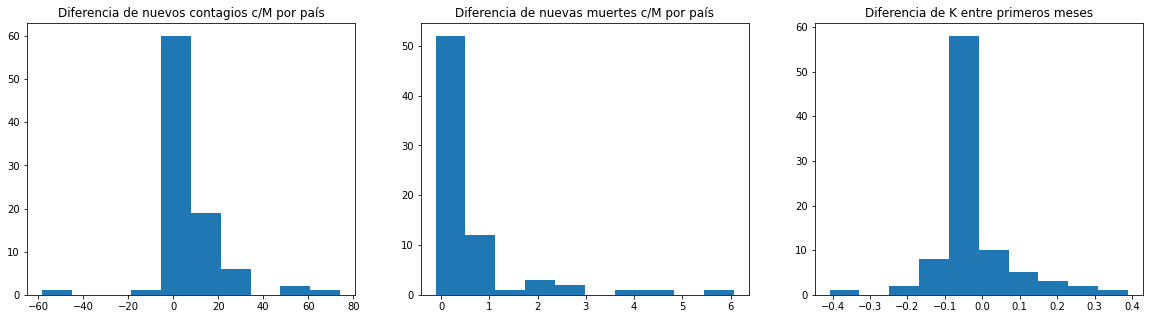

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.hist(paises_media.diferencia_contagios)
plt.title('Diferencia de nuevos contagios c/M por país')

plt.subplot(132)
plt.hist(paises_media.diferencia_muertes)
plt.title('Diferencia de nuevas muertes c/M por país')

plt.subplot(133)
plt.hist(paises_media.diferencia_k)
plt.title('Diferencia de K entre primeros meses')

### Observaciones

Los histogramas de la celda superior muestran los valores de los **tres indicadores** de cada país.

Es interesante notar que, dado que los indicadores representan **una diferencia entre valores en un momento en el tiempo y uno anterior**, si estos valores son negativos, indican una reducción del parámetro(media de contagios, media de muertes y K de ajuste exponencial). Se puede apreciar que no hay países con un **Indicador de muertes** negativo.

## Selección de países para la comparación

Para la selección de países que han implementado o no una política de cuarentena estricta, se usan los datos oficiales de BBC obtenidos del siguiente enlace: https://www.bbc.com/news/world-52103747

**Países con cuarentena estricta**: Argentina, Irán, Perú, República Checa, Austria, Suiza, Bamgladesh, Italia, España, Bélgica, Luxemburgo

**Países sin cuarentena**:  Chile, USA, Francia, Alemania, Finlandia, Filipinas, Reino Unido, Rusia, Taiwán, Malasia, Irlanda

**Países para testear nuestras regresiones logísticas**: Corea del Sur, Uruguay, Holanda, India, Somalia, Canadá, Israel

Los países han sido seleccionados para que **representen a la totalidad del mundo**, es decir, de diferentes continentes, situaciones socio-económicas, etc.

In [ ]:
# https://ig.ft.com/coronavirus-lockdowns/
# https://www.bbc.com/news/explainers-53640249
# https://www.bbc.com/news/world-52103747

seleccion_paises = ['df_ARG', 'df_PHL', 'df_CHL', 'df_USA', 
                    'df_GBR', 'df_FRA', 'df_RUS','df_ITA',
                    'df_CHE', 'df_MYS', 'df_TWN', 'df_ESP', 
                    'df_BEL','df_BGD', 'df_DEU', 'df_FIN', 
                    'df_IRN', 'df_PER', 'df_CZE', 'df_AUT',
                    'df_IRL', 'df_LUX']

test_paises = ['df_KOR', 'df_URU', 'df_NLD', 'df_IND', 'df_CAN', 'df_SOM', 'df_ISR']

seleccion_paises = paises_media[paises_media['paises'].isin(seleccion_paises)]

In [ ]:
seleccion_paises

,paises,diferencia_contagios,diferencia_muertes,diferencia_k
3,df_ARG,0.776067,0.088933,-0.062042
7,df_AUT,16.587200,1.716467,-0.079649
10,df_BGD,1.268000,0.035200,0.021395
12,df_BEL,10.029467,NaN,-0.408089
19,df_CHL,12.936000,0.090133,-0.035055
24,df_CZE,2.250400,0.619511,-0.077620
33,df_FIN,1.826333,NaN,0.389226
34,df_FRA,1.092333,0.015925,0.224712
35,df_DEU,1.500133,NaN,0.133822
45,df_IRN,15.124867,0.641400,-0.095424


In [ ]:
seleccion_paises['cuarentena'] = [1,1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
seleccion_paises.diferencia_muertes = seleccion_paises.diferencia_muertes.replace(np.nan,0)
seleccion_paises

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,paises,diferencia_contagios,diferencia_muertes,diferencia_k,cuarentena
3,df_ARG,0.776067,0.088933,-0.062042,1
7,df_AUT,16.587200,1.716467,-0.079649,1
10,df_BGD,1.268000,0.035200,0.021395,1
12,df_BEL,10.029467,0.000000,-0.408089,1
19,df_CHL,12.936000,0.090133,-0.035055,0
24,df_CZE,2.250400,0.619511,-0.077620,1
33,df_FIN,1.826333,0.000000,0.389226,0
34,df_FRA,1.092333,0.015925,0.224712,0
35,df_DEU,1.500133,0.000000,0.133822,0
45,df_IRN,15.124867,0.641400,-0.095424,1


### Observaciones

En la tabla superior se pueden apreciar todos los países que se están utilizando para el testeo, con sus respectivos valores para cada indicador y la clasificación de **Cuarentena Estricta**(1) y **Sin Cuarentena Estricta**(0)

## Diseño e Interpretación de las Regresiones Logísticas

Una regresión logística, interpretada de manera **no determinista** nos da un número entre 0 y 1 **que representa la probabilidad de que dicho país esté aplicando una cuarentena estricta**. Es decir, **cuanto más cercano a 0, se puede afirmar con mayor certeza que el país no aplic´+o una cuarentena estricta, mientras que, cuanto más cerca de 1 est+e, mayor probabilidad hay de que sí la haya implementadp**.

A continuación, se diseñarán las regesiones logísticas, y se aplicarán sobre nuestros datos.

Parámetros de Sigmoide (Contagios):  [6.03207472 0.19591197]
Parámetros de Sigmoide (Muertes):  [ 0.06777819 16.60102255]
Parámetros de Sigmoide (Diferencia de K):  [-2.76916251e-03 -2.21082765e+01]


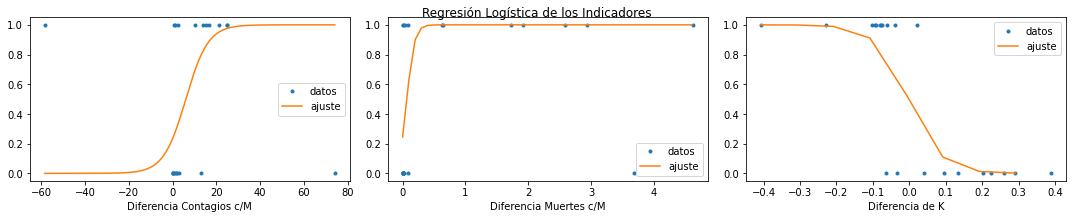

In [ ]:
medidores = ['diferencia_contagios', 'diferencia_muertes', 'diferencia_k']
parametros = ['Parámetros de Sigmoide (Contagios): ', 'Parámetros de Sigmoide (Muertes): ','Parámetros de Sigmoide (Diferencia de K): ']
titulos = ['Diferencia Contagios c/M', 
             'Diferencia Muertes c/M',
             'Diferencia de K']

plt.figure(figsize=(15,3))

i = 0
while i < 3:
  medidor = seleccion_paises[medidores[i]]
  p = [ np.median(medidor),1] # punto de partida para los parámetros
  popt, pcov = curve_fit(sigmoid, medidor, seleccion_paises.cuarentena,p, method='dogbox') #hago fiteo
  print(parametros[i], popt)
  sigmoidea=np.vectorize(sigmoid) #asi puedo poner un x que sea vector y sabe que tiene que hacer el barrido por indices
  x_plot=np.arange(min(medidor),max(medidor),0.1)
  cuarentena_ajustada=sigmoid(x_plot,popt[0],popt[1])
  plt.subplot(1,3,i+1)
  plt.plot(medidor,seleccion_paises.cuarentena,'.',label="datos")
  plt.plot(x_plot,cuarentena_ajustada,label="ajuste")
  plt.legend()
  plt.xlabel(titulos[i])
  i = i+1

plt.tight_layout()
plt.suptitle('\n'.join(['Regresión Logística de los Indicadores']), y = 1)
plt.show()

### Observaciones

Ahora que tenemos las regresiones logísticas hechas y ploteadas aquí arriba, se pueden comenzar a extraer conclusiones.

Se puede apreciar que el **Indicador 1**(diferencia de media de contagios) **presenta valores atípicos** tanto en los países con cuarentena como en los que no la aplicaron. Esto da la pauta de que, posiblemente, no resulte un indicador de marcada utilidad.

El **Indicador 2**(diferencia en la media de muertes) **no presenta valores negativos**, y aquellos países sin cuarentena se aglomeran cercanos al 0, mientras que los países que aplicaron una cuarentena estricta, presentan valores más elevados(lo cual va en contra de nuestra hipótesis inicial).

Sin lugar a dudas, el **Indicador 3**(diferencia entre el K de los ajustes exponenciales) presenta los datos más consistentes, yéndose hacia los extremos en direcciones opuestas para cada clasificación.

Ahora que ya están armados los clasificadores, se generará una tabla con las **probabilidades de que cada país dé 1 en la clasificación**.

In [ ]:
test_paises = paises_media[paises_media['paises'].isin(test_paises)]

In [ ]:
test_paises = test_paises.replace(np.nan,0)

In [ ]:
test_paises['contagios_predict'] = [sigmoid(x, 6.03207472, 0.19591197) for x in test_paises.diferencia_contagios]
test_paises['muertes_predict'] = [sigmoid(x, 0.06777819, 16.60102255) for x in test_paises.diferencia_muertes]
test_paises['k_predict'] = [sigmoid(x, -2.76916251e-03, -2.21082765e+01) for x in test_paises.diferencia_k]

In [ ]:
test_paises

,paises,diferencia_contagios,diferencia_muertes,diferencia_k,contagios_predict,muertes_predict,k_predict
18,df_CAN,0.138467,0.000000,0.060921,0.239645,0.245050,0.196537
43,df_IND,0.004667,0.000000,0.122399,0.234901,0.245050,0.059120
48,df_ISR,53.782200,0.360200,-0.042419,0.999913,0.992267,0.706113
57,df_NLD,30.202200,6.071467,-0.082120,0.991296,1.000000,0.852495
75,df_SOM,1.895000,0.088438,-0.141287,0.307783,0.584913,0.955315
78,df_KOR,8.321533,0.034067,0.059251,0.610290,0.363629,0.202433


## Resultados y Conclusiones

A partir de la tabla superior se extraen los siguientes datos:

**Canadá**: Indicador 1: 24%, Indicador 2: 24%, Indicador 3: 19%

Los tres indicadores coinciden en que **Es baja la probabilidad de que Canadá haya aplicado una cuarentena estricta** en el lapso de tiempo estudiado.

**India**: Indicador 1: 23%, Indicador 2: 24%, Indicador 3: 5%
Los tres indicadores coinciden en que **Es baja la probabilidad de que India haya aplicado una cuarentena estricta** en el lapso de tiempo estudiado.

**Israel**: Indicador 1: 99%, Indicador 2: 99%, Indicador 3: 70%

Los tres indicadores coinciden en que **Es alta la probabilidad de que Israel haya aplicado una cuarentena estricta** en el lapso de tiempo estudiado.

**Holanda**: Indicador 1: 99%, Indicador 2: 100%, Indicador 3: 85%

Los tres indicadores coinciden en que **Es alta la probabilidad de que Holanda haya aplicado una cuarentena estricta** en el lapso de tiempo estudiado.

**Somalia**: Indicador 1: 30%, Indicador 2: 58%, Indicador 3: 95%

Dos indicadores coinciden en que **Es alta la probabilidad de que Somalia haya aplicado una cuarentena estricta** en el lapso de tiempo estudiado. El indicador 1 discrepa, indicando una baja probabilidad de cuarentena estricta.

**Corea del Sur**: Indicador 1: 61%, Indicador 2: 36%, Indicador 3: 20%

Dos indicadores coinciden en que **Es baja la probabilidad de que Corea del Sur haya aplicado una cuarentena estricta** en el lapso de tiempo estudiado. El indicador 1 discrepa, indicando una alta probabilidad de cuarentena estricta.

De los sitios de investigación antes expuestos(BBC), se obtuvo la siguiente información:|

**Corea del Sur, Canadá e India no aplicaron una cuarentena estricta en la ventana temporal estudiada**

**Holanda, Somalia e Israel aplicaron una cuarentena estricta en la ventana temporal estudiada**

#### Podemos concluir que los indicadores 2 y 3 han predicho con buen nivel de probabilidad, todos los casos correctamente. El indicador 1 ha fallado en algunos, pero en líneas generales también predice bien. 

### Investigación Adicional: Resolviendo un sistema SEIR

Un modelo epidemiológico SEIR toma en consideración a la **Población Susceptible**(S), **Población Expuesta**(E), **Población Infectada**(I) y **Población Recuperada**(R).

Para resolver dicho sistema, se utilizan ecuaciones diferenciales de primer orden que, en este caso, se aproximan de manera simplificada, siguiendo el trabajo hecho en: http://web.pdx.edu/~gjay/teaching/mth271_2020/html/09_SEIR_model.html

A continuación, se define una función para dicho cálculo, y un gráfico interactivo para modificar los parámetros **ganna, sigma y beta** que son los responsables de determinar los valores SEIR de infectados, recuperados.

In [ ]:
from ipywidgets import interact
from scipy.integrate import solve_ivp
    
def ivp_solver(beta, sigma, gamma):

    def seir_f(t, y, beta, sigma, gamma):
        """
        S: Susceptibles
        E: Expuestos
        I: Infectados
        R: Recuperados

        beta: probabilidad de infeccion si el contacto ocurre
        sigma: tasa a la que los infectados pasan a R
        gamma: tasa a la que individuos expuestos se infectan
        
        """
        s, e, i, r = y
        return np.array([-beta * i * s,
                        -sigma * e + beta * i * s, 
                        -gamma * i + sigma * e, 
                        gamma * i])
        

    sol = solve_ivp(seir_f, [0, 180], [0.9, 0.1, 0, 0], 
              rtol=1e-6, args=(beta, sigma, gamma))
    
    with plt.style.context("ggplot"):
      plt.figure(figsize=(20,20))
      fig = plt.figure(); ax = fig.gca()
      curves = ax.plot(sol.t, sol.y.T)
      ax.legend(curves, ['S', 'E', 'I', 'R'])
      plt.title('Modelo SEIR con valores iniciales')

In [ ]:
interact(ivp_solver, beta=2.2/2.3, sigma=(1/2.3,1), gamma=(1/5.2,1))

interactive(children=(FloatSlider(value=0.9565217391304349, description='beta', max=2.8695652173913047, min=-0…

<function __main__.ivp_solver>

## Cierre de Trabajo

Como concluir este trabajo, podemos plantear alguna línea de investigación con el que se pudiera iterar sobre el mismo.

Buscando en sitios de relevancia científica, podrían intentar encontrarse valores empíricos para **gamma, sigma y beta** y de esta forma poder estudiar la curva de infectados durante la ventana temporal estudiada más atrás. Así, a través de una ciferencia de cuadrados mínimos u otras funciones de costo, se podría estudiar si la pandemia a nivel mundial o nacional tuvo un crecimiento exponencial que coincide con el de este modelo.